#Institución Universitaria Pascual Bravo

#Curso: Reconocimiento de patrones 2024-1

#Docente: Juan Carlos Briñez de León



#Reconocimiento de patrones (Aproximación metodológica)

#1. Ejercicio anterior

Cargando y etiquetando los datos

In [1]:
#Conectando google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Etiqueta:  2


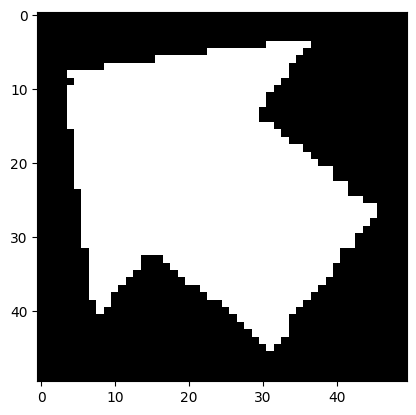

In [2]:
import matplotlib.pyplot as plt
import cv2
from google.colab import output
import numpy as np
import os
import time

Ruta = "/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Semana 6/Dataset flechas 2"


imagenes = []
etiquetas = []

clases = sorted(os.listdir(Ruta))
for i, label in enumerate(clases):
  carpeta_clase = os.path.join(Ruta, label)
  for archivo in os.listdir(carpeta_clase):
    Ruta_img = os.path.join(carpeta_clase, archivo)

    output.clear()
    Img=cv2.imread(Ruta_img)
    #Procesando la imagen
    Gris=cv2.cvtColor(Img,cv2.COLOR_BGR2GRAY)
    Bin = Gris > 100

    Bin = cv2.resize(np.uint8(Bin), (50,50))

    print('Etiqueta: ',i)
    plt.imshow(Bin,vmin='0',vmax='1',cmap = 'gray')
    plt.show()
    time.sleep(0.5)

    imagenes.append(np.array(Bin))
    etiquetas.append(i)

Extracción de características

Etiqueta:  [2.]


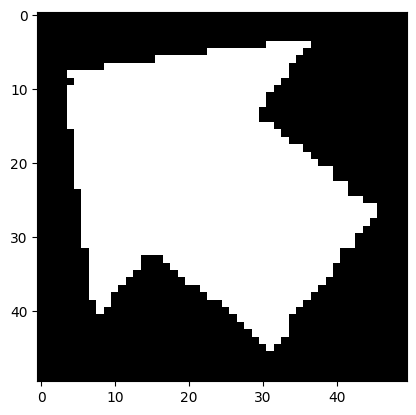

In [3]:
#Recorriendo el directorio, midiendo característica de  área
import time
import matplotlib.pyplot as plt
import cv2
from google.colab import output
import numpy as np

X = np.zeros((len(imagenes),6)) # Vector de características geométricas
Y = np.zeros((len(imagenes),1)) # Vector de etiquetas, aunque ya se tiene, le pongo otro nombre
for k in range(len(imagenes)):
  output.clear()

  Y[k] = etiquetas[k]
  Bin=imagenes[k]
  plt.imshow(Bin,vmin='0',vmax='1',cmap = 'gray')
  print('Etiqueta: ',Y[k])
  plt.show()
  time.sleep(0.5)

  # Encontrar los contornos de la imagen
  contours, _ = cv2.findContours(np.uint8(Bin), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if len(contours) > 0:
    # Tomar solo el contorno más grande (puede haber varios)
    largest_contour = max(contours, key=cv2.contourArea)

    # Calcular área
    area = cv2.contourArea(largest_contour)

    # Calcular perímetro
    perimeter = cv2.arcLength(largest_contour, closed=True)

    # Calcular el centro de masa
    M = cv2.moments(largest_contour)
    center_x = int(M['m10'] / M['m00'])
    center_y = int(M['m01'] / M['m00'])

    # Calcular la circularidad
    circularity = (4 * np.pi * area) / (perimeter ** 2)

    # Calcular la elipticidad
    _, (major_axis, minor_axis), _ = cv2.fitEllipse(largest_contour)
    ellipticity = major_axis / minor_axis


    # Almacenando resultados
    X[k,0] = area
    X[k,1] = perimeter
    X[k,2] = ellipticity
    X[k,3] = center_x
    X[k,4] = center_y
    X[k,5] = circularity

Dividiendo los datos en training y testing

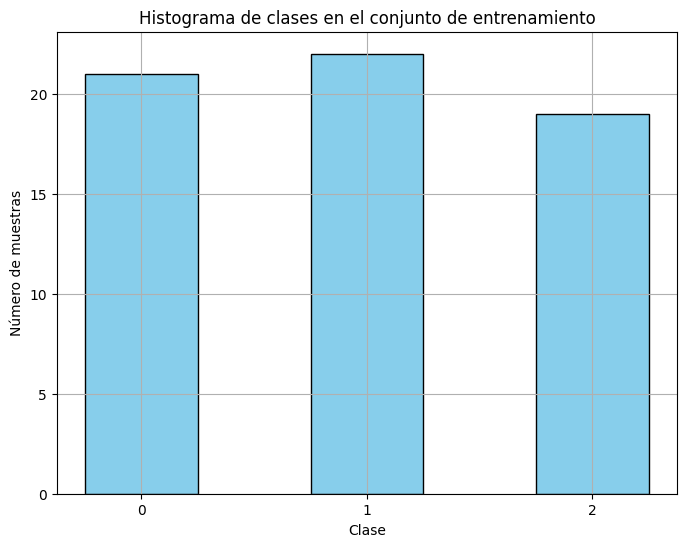

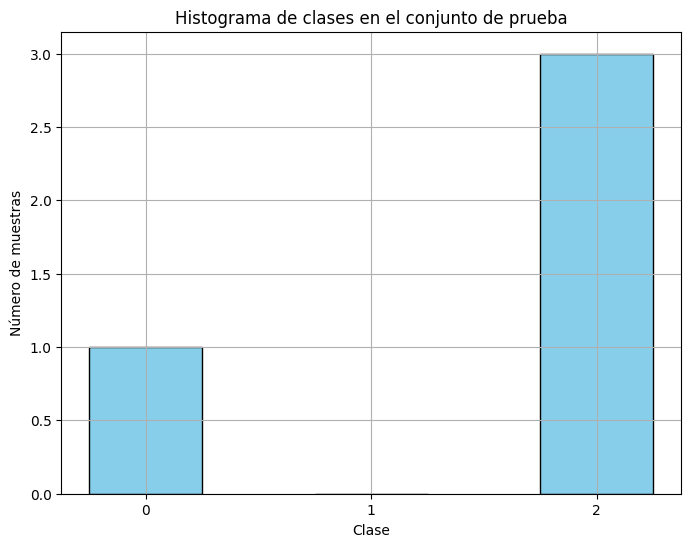

In [4]:
#Partiendo los datos en entrenamiento y evaluación
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, random_state=42)

# Dibujar el histograma del vector test de salida
hist_train, bins = np.histogram(Y_train, bins=[0,1,2,3])
plt.figure(figsize=(8, 6))
plt.bar(bins[:-1], hist_train, width=0.5, color='skyblue', edgecolor='black')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Histograma de clases en el conjunto de entrenamiento')
plt.xticks(bins[:-1])
plt.grid(True)
plt.show()


# Dibujar el histograma del vector test de salida
hist_test, bins = np.histogram(Y_test, bins=[0,1,2,3])
plt.figure(figsize=(8, 6))
plt.bar(bins[:-1], hist_test, width=0.5, color='skyblue', edgecolor='black')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Histograma de clases en el conjunto de prueba')
plt.xticks(bins[:-1])
plt.grid(True)
plt.show()

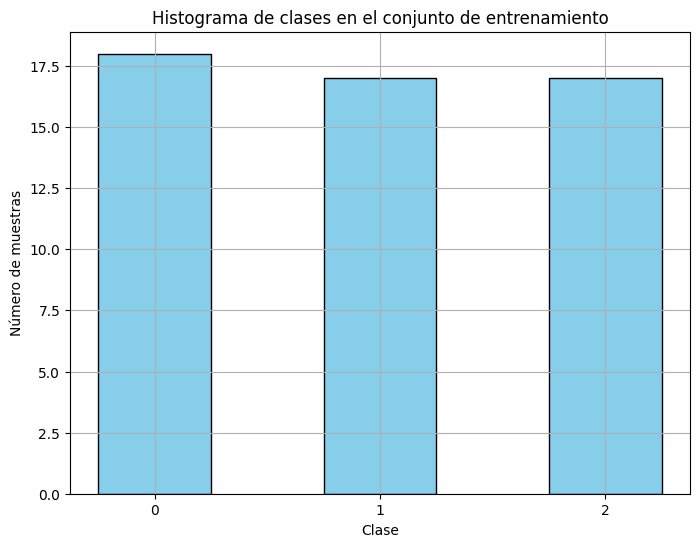

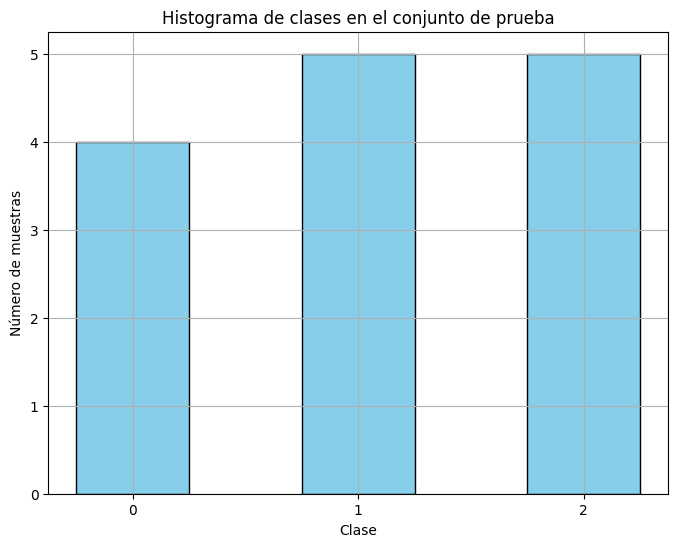

In [5]:
#Ojo, modificación para dividir los datos garantizando el balanceo de clases
from sklearn.model_selection import StratifiedShuffleSplit
Indices = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in Indices.split(X, Y):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index]


# Dibujar el histograma del vector test de salida
hist_train, bins = np.histogram(Y_train, bins=[0,1,2,3])
plt.figure(figsize=(8, 6))
plt.bar(bins[:-1], hist_train, width=0.5, color='skyblue', edgecolor='black')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Histograma de clases en el conjunto de entrenamiento')
plt.xticks(bins[:-1])
plt.grid(True)
plt.show()


# Dibujar el histograma del vector test de salida
hist_test, bins = np.histogram(Y_test, bins=[0,1,2,3])
plt.figure(figsize=(8, 6))
plt.bar(bins[:-1], hist_test, width=0.5, color='skyblue', edgecolor='black')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Histograma de clases en el conjunto de prueba')
plt.xticks(bins[:-1])
plt.grid(True)
plt.show()

Escalando los datos

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

Entrenando un clasificador

In [8]:
#Implementando un clasificador por comparación (KNN)
from sklearn.neighbors import KNeighborsClassifier as KNN

# Inicializar el clasificador KNN
Modelo_knn = KNN(n_neighbors=3)

# Entrenar el clasificador KNN con el conjunto de entrenamiento
Modelo_knn.fit(X_train_normalized, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

Evaluando el desempeño

In [9]:
#Métricas de evaluación
from sklearn.metrics import accuracy_score
Y_pred = Modelo_knn.predict(X_test_normalized)

# Calcular la precisión del modelo
accuracy = accuracy_score(Y_test, Y_pred)
print("Precisión del modelo KNN:", accuracy)

Precisión del modelo KNN: 1.0


Guardando Modelo entrenado

In [10]:
# Guardar el modelo entrenado en un archivo
import joblib

joblib.dump(Modelo_knn, '/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Semana 7/Modelo_knn_2.pkl')

['/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Semana 7/Modelo_knn_2.pkl']

Utilizando el modelo entrenado para predecir nuevos casos

In [11]:
from google.colab import files
import cv2
import numpy as np


# Cargar el modelo desde el archivo
Modelo_entrenado = joblib.load('/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Semana 7/Modelo_knn_2.pkl')

# Cargar archivos desde el sistema local
uploaded = files.upload()

# Obtener el nombre del archivo cargado
Nombre_archivo = list(uploaded.keys())[0]

Imagen=cv2.imread(Nombre_archivo)

#Procesando la imagen
Gris=cv2.cvtColor(Imagen,cv2.COLOR_BGR2GRAY)
Bin = Gris > 100
Bin = cv2.resize(np.uint8(Bin), (50,50))

plt.imshow(Bin,vmin='0',vmax='1',cmap = 'gray')
plt.show()

#Midiendo el área de las letras (Igual que en el entrenamiento)
X_new = np.zeros((1,6))

# Encontrar los contornos de la imagen
contours, _ = cv2.findContours(np.uint8(Bin), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) > 0:
  # Tomar solo el contorno más grande (puede haber varios)
  largest_contour = max(contours, key=cv2.contourArea)

  # Calcular área
  area = cv2.contourArea(largest_contour)

  # Calcular perímetro
  perimeter = cv2.arcLength(largest_contour, closed=True)

  # Calcular el centro de masa
  M = cv2.moments(largest_contour)
  center_x = int(M['m10'] / M['m00'])
  center_y = int(M['m01'] / M['m00'])

  # Calcular la circularidad
  circularity = (4 * np.pi * area) / (perimeter ** 2)

  # Calcular la elipticidad
  _, (major_axis, minor_axis), _ = cv2.fitEllipse(largest_contour)
  ellipticity = major_axis / minor_axis

  # Almacenando resultados
  X_new[0,0] = area
  X_new[0,1] = perimeter
  X_new[0,2] = ellipticity
  X_new[0,3] = center_x
  X_new[0,4] = center_y
  X_new[0,5] = circularity

  #Ojo, se debe normalizar
  X_new_normalized = scaler.transform(X_new)

print(Modelo_entrenado.predict(X_new_normalized))

IndexError: list index out of range

#2. Métricas de desempeño

Accuracy: 1.00
 


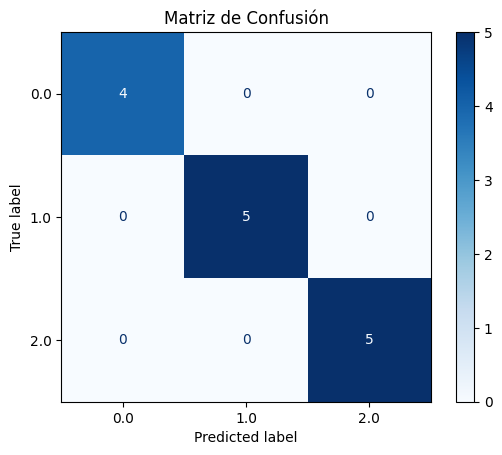

 
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         5
         2.0       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay
import seaborn as sns

 # Calcular métricas
accuracy = Modelo_knn.score(X_test_normalized, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

# Calcular la curva ROC y el área bajo la curva (AUC)
#Y_pred_prob = Modelo_knn.predict_proba(X_test)[:, 1]
#fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob)
#roc_auc = auc(fpr, tpr)

# Mostrar resultados
print(f"Accuracy: {accuracy:.2f}")
print('==================')
print(' ')

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Modelo_knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()
print('==================')

print(' ')
print("Classification Report:")
print(report)
print('==================')

# Visualizar la curva ROC
#print(' ')
#plt.figure()
#lw = 2
#plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic Curve')
#plt.legend(loc="lower right")
#plt.show()

#3. Incluyendo características (Momentos de Hu, Alto y Ancho)

Etiqueta:  [2.]


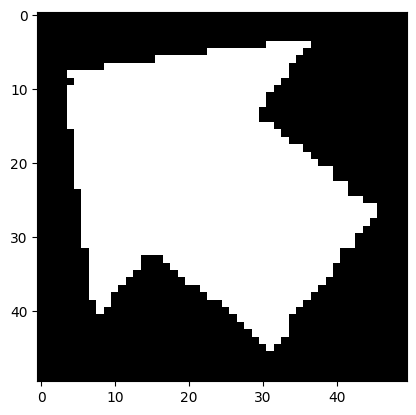

In [13]:
#Recorriendo el directorio, midiendo característica de  área
import time
import matplotlib.pyplot as plt
import cv2
from google.colab import output
import numpy as np

X = np.zeros((len(imagenes),15)) # Vector de características geométricas
Y = np.zeros((len(imagenes),1)) # Vector de etiquetas, anque ya se tiene, le pongo otro nombre
for k in range(len(imagenes)):
  output.clear()

  Y[k] = etiquetas[k]
  Bin=imagenes[k]
  plt.imshow(Bin,vmin='0',vmax='1',cmap = 'gray')
  print('Etiqueta: ',Y[k])
  plt.show()
  time.sleep(0.5)

  # Encontrar los contornos de la imagen
  contours, _ = cv2.findContours(np.uint8(Bin), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if len(contours) > 0:
    # Tomar solo el contorno más grande (puede haber varios)
    largest_contour = max(contours, key=cv2.contourArea)

    # Calcular área
    area = cv2.contourArea(largest_contour)

    # Calcular perímetro
    perimeter = cv2.arcLength(largest_contour, closed=True)

    # Calcular el centro de masa
    M = cv2.moments(largest_contour)
    center_x = int(M['m10'] / M['m00'])
    center_y = int(M['m01'] / M['m00'])

    # Calcular la circularidad
    circularity = (4 * np.pi * area) / (perimeter ** 2)

    # Calcular la elipticidad
    _, (major_axis, minor_axis), _ = cv2.fitEllipse(largest_contour)
    ellipticity = major_axis / minor_axis

    #Calcular los momentos de Hu
    Hu_moments = np.transpose(cv2.HuMoments(M)) # Siete valores

    #Agregando alto y ancho
    P1,P2,Ancho,Alto = cv2.boundingRect(np.uint8(Bin))

    # Almacenando resultados
    X[k,0] = area
    X[k,1] = perimeter
    X[k,2] = ellipticity
    X[k,3] = center_x
    X[k,4] = center_y
    X[k,5] = circularity
    X[k,6:13] = Hu_moments
    X[k,13] = Alto
    X[k,14] = Ancho


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 1.00
 


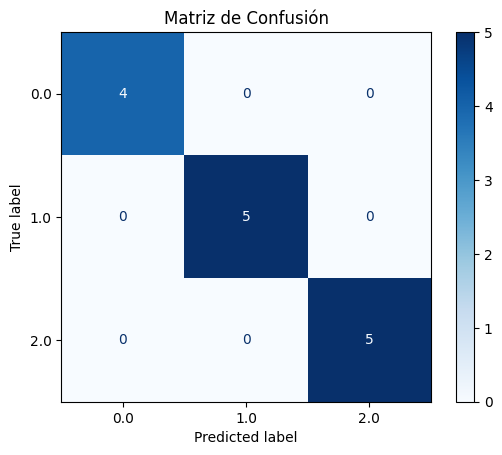

 
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       1.00      1.00      1.00         5
         2.0       1.00      1.00      1.00         5

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
Indices = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in Indices.split(X, Y):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

#Implementando un clasificador por comparación (KNN)
from sklearn.neighbors import KNeighborsClassifier as KNN

# Inicializar el clasificador KNN
Modelo_knn = KNN(n_neighbors=3)

# Entrenar el clasificador KNN con el conjunto de entrenamiento
Modelo_knn.fit(X_train_normalized, Y_train)

Y_pred = Modelo_knn.predict(X_test_normalized)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

 # Calcular métricas
accuracy = Modelo_knn.score(X_test_normalized, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

# Mostrar resultados
print(f"Accuracy: {accuracy:.2f}")
print('==================')
print(' ')

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Modelo_knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()
print('==================')

print(' ')
print("Classification Report:")
print(report)
print('==================')